In [41]:
# -*- coding: utf-8 -*- 
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the CICIDS2017 dataset. 
# implemented Advanced Ensemble techniques: LightGBM  
# This project we use many Machine Learning models to predict the attack types. using 3 different datasets, and this includes ensamble techniques and individual models. 
# Tus 2/13/2024   

import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/home/ibibers@ads.iu.edu/Intrusion_Detection_System_IDS/Advanced_Ensemble_techniques/Stacking/CICIDS2017_combined_dataset.csv')

# Drop duplicates: same observation but multiple occurences
main_df_1 = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value, the model wont learn form columns like this.
one_value = main_df_1.columns[main_df_1.nunique() == 1]
main_df_2 = main_df_1.drop(columns = one_value, axis=1)

# Fill nan values
main_df_2['Flow Bytes/s'] = main_df_2['Flow Bytes/s'].fillna(main_df_2['Flow Bytes/s'].mean())

# Remove leading space character in all feature names
main_df_2.rename(columns=lambda x: x.lstrip(), inplace=True)

# Checking numbers of missing values on the df
# main_df_2.isna().sum().sum()

sample_df_1 = main_df_2.copy()

# Extract subsample of data
print (" Extract subsample of data: ")
print (sample_df_1['Label'].value_counts())

 Extract subsample of data: 
Label
BENIGN                        2096484
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [42]:
# Label encoding to convert categorical data to numerical data
le = LabelEncoder()
sample_df_1['Label'] = le.fit_transform(sample_df_1['Label'])

# Extract subsample of data
print (" Extract subsample of data: ")
print (sample_df_1['Label'].value_counts())

 Extract subsample of data: 
Label
0     2096484
4      172849
2      128016
10      90819
3       10286
7        5933
6        5385
5        5228
11       3219
1        1953
12       1470
14        652
9          36
13         21
8          11
Name: count, dtype: int64


In [43]:
# sample_df_1.shape
# sample_df_1.info()

# Take a 40% random sample of the dataset
# sample_df_1 = sample_df_1.sample(frac=0.05, random_state=42)

print("Sampled Dataset Overview:")
# print(sample_df_2.head())
# print (sample_df_2.info())

dropped_df = ['Label', 'Flow Packets/s', 'Flow Bytes/s']
X = sample_df_1.drop( dropped_df, axis=1) 
y = sample_df_1['Label']  

Sampled Dataset Overview:


In [44]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Light GBM Light GBM beats all the other algorithms when the dataset is extremely large.
train_data=lgb.Dataset(X_train,label=y_train)
#define parameters
# params = {'learning_rate':0.001}
params = {
    'learning_rate': 0.001,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
}

# lgb_model= lgb.train(params, train_data, 100) 
lgb_model = lgb.train(params, train_data, num_boost_round=200)

# Make predictions on the test set
y_pred=lgb_model.predict(X_test)

# Threshold the predicted probabilities at 0.5 to obtain binary predictions
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred]


# for i in range(0,185):
#    if y_pred[i]>=0.5: 
#      y_pred[i]=1
# else: 
#    y_pred[i]=0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.532849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14073
[LightGBM] [Info] Number of data points in the train set: 2017889, number of used features: 68
[LightGBM] [Info] Start training from score 0.812844


In [45]:
# Evaluate the performance of the stacking model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of LGB Model:", accuracy)

Accuracy of LGB Model: 0.0007988534569739114


In [46]:
# You can also print other evaluation metrics like confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[     0 419148      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0    403      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0  25498      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0   2032      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0  34853      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0   1038      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0   1085      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0   1160      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      2      0      0      0      0      0      0      0      0
       0      0      0      0

In [47]:

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    419148
           1       0.00      1.00      0.00       403
           2       0.00      0.00      0.00     25498
           3       0.00      0.00      0.00      2032
           4       0.00      0.00      0.00     34853
           5       0.00      0.00      0.00      1038
           6       0.00      0.00      0.00      1085
           7       0.00      0.00      0.00      1160
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00     18187
          11       0.00      0.00      0.00       633
          12       0.00      0.00      0.00       294
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00       135

    accuracy                           0.00    504473
   macro avg       0.00      0.07      0.00    504473
we

/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# Convert the encoded labels to the original labels by using inverse_transform 
y_pred = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

# Create a mapping between numerical labels and their corresponding real labels
label_mapping = {label: le.inverse_transform([label])[0] for label in set(y_test)}
print (label_mapping)

{0: 'BENIGN', 1: 'Bot', 2: 'DDoS', 3: 'DoS GoldenEye', 4: 'DoS Hulk', 5: 'DoS Slowhttptest', 6: 'DoS slowloris', 7: 'FTP-Patator', 8: 'Heartbleed', 9: 'Infiltration', 10: 'PortScan', 11: 'SSH-Patator', 12: 'Web Attack � Brute Force', 13: 'Web Attack � Sql Injection', 14: 'Web Attack � XSS'}


In [49]:
# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.00


In [50]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:


/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.00      0.00      0.00    419148
                       Bot       0.00      1.00      0.00       403
                      DDoS       0.00      0.00      0.00     25498
             DoS GoldenEye       0.00      0.00      0.00      2032
                  DoS Hulk       0.00      0.00      0.00     34853
          DoS Slowhttptest       0.00      0.00      0.00      1038
             DoS slowloris       0.00      0.00      0.00      1085
               FTP-Patator       0.00      0.00      0.00      1160
                Heartbleed       0.00      0.00      0.00         2
              Infiltration       0.00      0.00      0.00         4
                  PortScan       0.00      0.00      0.00     18187
               SSH-Patator       0.00      0.00      0.00       633
  Web Attack � Brute Force       0.00      0.00      0.00       294
Web Attack � Sql Injection       0.00      0.00

/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


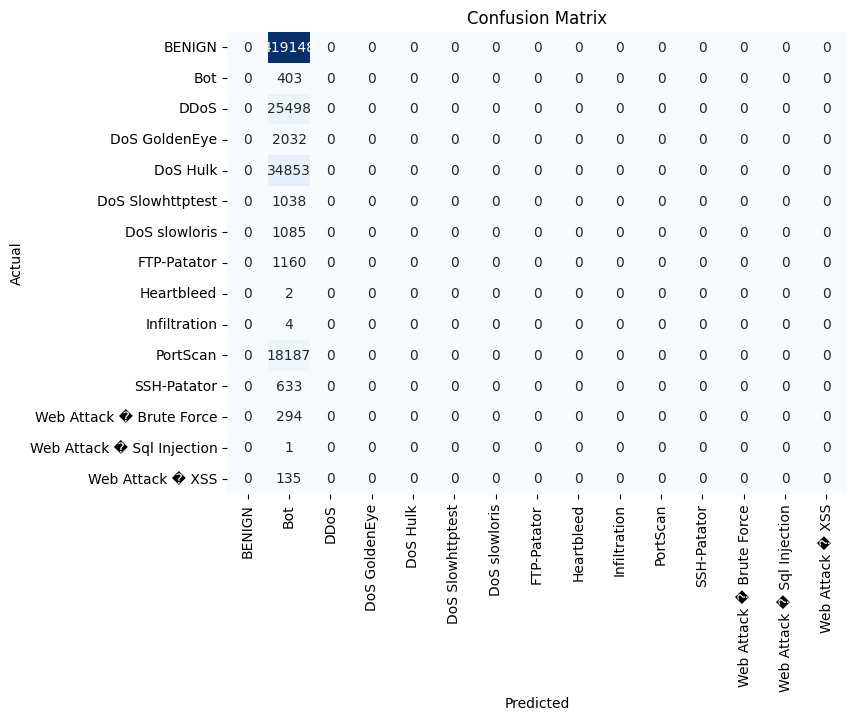

In [51]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test_labels, y_pred , labels = le.classes_)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,  xticklabels=le.classes_.tolist(), yticklabels=le.classes_.tolist()) 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [52]:
# importances of features in the decision tree model 
importance = lgb_model.feature_importances_
importance_dict = dict(zip(X.columns.values, importance))
sorted_importance = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(7, 13))
sns.barplot(x=list(sorted_importance.values()), y=list(sorted_importance.keys()), palette='cubehelix')
plt.xlabel('Importance Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()




AttributeError: 'Booster' object has no attribute 'feature_importances_'